# Time-Series Classification: CNN1D

## Import libraries


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_visualizer
import warnings
import logging
import tsaug

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


## Set seed for reproducibility


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Data Preprocessing

### Load Data

In [3]:
data_x = np.load('x_train.npy')
data_y = np.load('y_train.npy')
classes = np.load('Classes.npy')

In [5]:
training_labels = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain' : 6,
    'Echoes' : 7,
    'Wearing' : 8,
    'Sorrow' : 9,
    'Hey' : 10,
    'Shine' : 11
}

In [6]:
classes = np.reshape(classes, (2429,36))

In [7]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (
    TimeWarp() * 3 +# random time warping 5 times in parallel
    Crop(size=36)+
    Quantize(n_levels=[10, 20, 30])+
    Drift(max_drift=(0.1, 0.5))+
    Reverse())

In [8]:
X_aug, Y_aug = my_augmenter.augment(data_x, classes)
X_aug.shape, Y_aug.shape

((7287, 36, 6), (7287, 36))

In [45]:
data_t = np.zeros((2429, 36,3))
for i in range(0):
    for j in range(36):
        for k in range(6):
            data_t[i][j][k] = data_x[i][j][k]

In [46]:
data_t.shape

(2429, 36, 3)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, Y_aug, test_size=0.1, random_state=seed, stratify=Y_aug)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6558, 36, 6), (729, 36, 6), (6558, 36), (729, 36))

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]
 [11. 11. 11. ... 11. 11. 11.]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

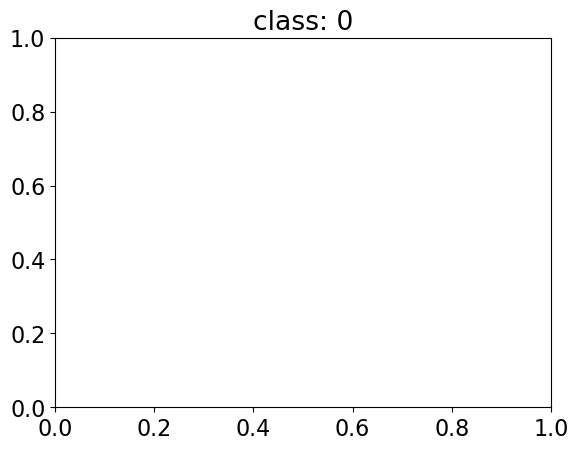

In [16]:

print(classes)
for c in range(12):
    plt.figure()
    plt.title("class: " + str(c)) 
    c_x_train = X_train[y_train == c]
    for i in range(0,6):
        #print(c_x_train[0].shape)
        plt.plot(c_x_train[0,:,i], label="label " + str(i))
    plt.legend(loc="best")
    plt.show()
    #plt.clos

In [59]:
y_test_classes = y_test

In [60]:
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

y_train.shape, y_test.shape

((6558, 36, 12), (729, 36, 12))

In [20]:
from pyts.image import MarkovTransitionField
import matplotlib.pyplot as plt
 # both N x T time series samples

mtf = MarkovTransitionField(image_size=256)
im_train = mtf.fit_transform(X_train)
im_test = mtf.transform(X_test)

# plot one image
plt.imshow(im_train[0])
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.

In [62]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 200

In [43]:
data_t = np.zeros((2429,36,6))
for i in range(2429):
    for j in range(36):
        for k in range(3):
            data_t[i][j][k] = data_x[i][j][k]*2
        for k in range(3,6):
            data_t[i][j][k] = data_x[i][j][k]*0.5



In [12]:
resnet =tfk.models.load_model('resnet')

In [24]:
#NORMALIZZAZIONE A MEDIA E VARIANZA NON ESEGUITA

import torch
  
# Step 2: creating a torch tensor
t = torch.tensor(data_t)
print("Tensor before Normalize:\n", t)
  
# Step 3: Computing the mean, std and variance
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, Std and Var before Normalize:\n", 
      mean, std, var)
  
# Step 4: Normalizing the tensor
t  = (t-mean)/std
print("Tensor after Normalize:\n", t)
  
# Step 5: Again compute the mean, std and variance
# after Normalize
mean, std, var = torch.mean(t), torch.std(t), torch.var(t)
print("Mean, std and Var after normalize:\n", 
      mean, std, var)

Tensor before Normalize:
 tensor([[[ 1.7597e+01,  8.1713e+00, -1.7842e+00],
         [ 2.2974e-01, -5.8956e+00,  1.6837e+01],
         [-2.9654e+01, -2.1296e+01,  2.9103e+01],
         ...,
         [ 1.1982e+02,  2.1849e+02,  1.6398e+03],
         [ 9.1591e+01,  1.0378e+02,  1.8238e+03],
         [ 4.3719e+01,  3.0689e+01,  9.5092e+02]],

        [[ 2.4209e+00, -5.6039e-01,  2.3654e+01],
         [ 1.6847e+00,  2.3989e+01,  1.7803e+01],
         [ 5.0692e-01,  5.0281e+01,  5.1196e+01],
         ...,
         [-1.5618e+01, -7.4233e+00,  3.7833e+00],
         [-1.0702e+01, -6.3568e+00, -4.6464e+00],
         [-4.6352e+00, -3.2769e+00, -5.9048e+00]],

        [[ 3.9688e+01,  7.0129e+02,  3.0038e+03],
         [ 1.6399e+02,  1.2559e+03,  3.3818e+03],
         [ 2.7545e+02,  1.7005e+03,  3.0922e+03],
         ...,
         [ 3.1521e+01,  9.1987e+00, -4.7701e+00],
         [ 2.5363e+01,  5.1979e+00,  6.0153e+00],
         [ 1.2557e+01,  2.2734e+00,  4.4831e+00]],

        ...,

        [[ 5

In [25]:
t = np.array(t)

## Model

In [46]:
def build_autoencoder(input_shape, classes):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    x = tfkl.Conv1D(128, kernel_size=8, padding="same", activation="relu")(bilstm)
    x = tfkl.Dropout(0.1, seed=seed, name='Drop4')(x)
    x = tfkl.Conv1D(128, kernel_size=5, padding="same", activation="relu")(x)
    x = tfkl.Conv1DTranspose(filters=128, kernel_size=8, padding="same", activation="relu")(x)
    x = tfkl.Dropout(0.2, seed=seed, name='Drop2')(x)
    x = tfkl.Conv1DTranspose(filters=128, kernel_size=8, padding="same", activation="relu")(x)
    #x = tfk.layers.Activation('relu')(x)
    #x = tfkl.Conv1DTranspose(filters=1, kernel_size=3, padding="same")(x)

    #gap = tfkl.GlobalAveragePooling1D()(x)

    #bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences = True))(x)
    classifier = tfkl.Dense(128, activation='relu')(x)
    classifier = tfkl.Dropout(0.5, seed=seed, name='Drop3')(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [47]:
import keras_tuner
model = build_autoencoder(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 36, 512)          538624    
 nal)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 36, 128)           524416    
                                                                 
 Drop4 (Dropout)             (None, 36, 128)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 36, 128)           82048     
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 36, 128)          131200    
 ranspose)                                                   

In [109]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_autoencoder,
    objective="val_accuracy",
    max_trials=25,
    executions_per_trial=1,
    overwrite=False,
    directory="hp_tuning",
    project_name="hw1_aut_param_3",
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project hp_tuning\hw1_aut_param_3\oracle.json


INFO:tensorflow:Reloading Oracle from existing project hp_tuning\hw1_aut_param_3\oracle.json


INFO:tensorflow:Reloading Tuner from hp_tuning\hw1_aut_param_3\tuner0.json


INFO:tensorflow:Reloading Tuner from hp_tuning\hw1_aut_param_3\tuner0.json


Search space summary
Default search space size: 3
convUnits0 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
dropOut0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.2, 'sampling': None}
convUnits1 (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}


In [135]:
tuner.search(x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ])


Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
128               |128               |convUnits0
0                 |0                 |dropOut0
128               |128               |convUnits1

Epoch 1/200


KeyboardInterrupt: 

## Training

In [48]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
93/93 [==============================] - 24s 235ms/step - loss: 1.9463 - accuracy: 0.3594 - val_loss: 1.7011 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 2/200
93/93 [==============================] - 22s 232ms/step - loss: 1.6604 - accuracy: 0.4513 - val_loss: 1.5401 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 3/200
93/93 [==============================] - 22s 235ms/step - loss: 1.5081 - accuracy: 0.4962 - val_loss: 1.5422 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 4/200
93/93 [==============================] - 22s 242ms/step - loss: 1.3689 - accuracy: 0.5384 - val_loss: 1.4531 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 5/200
93/93 [==============================] - 23s 242ms/step - loss: 1.2714 - accuracy: 0.5717 - val_loss: 1.4054 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 6/200
93/93 [==============================] - 22s 241ms/step - loss: 1.1640 - accuracy: 0.6017 - val_loss: 1.3976 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 7/200
93/93 [==============================] - 23s 2

## Plot

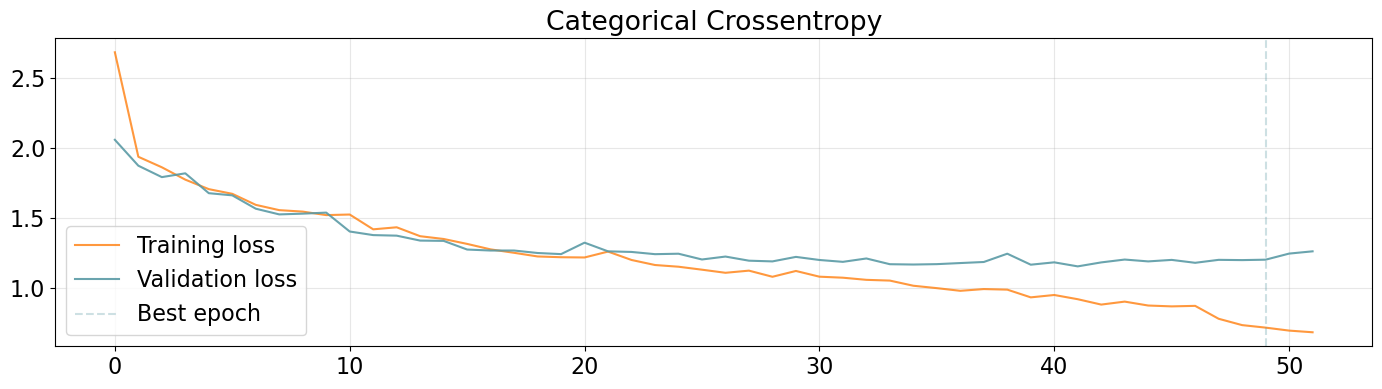

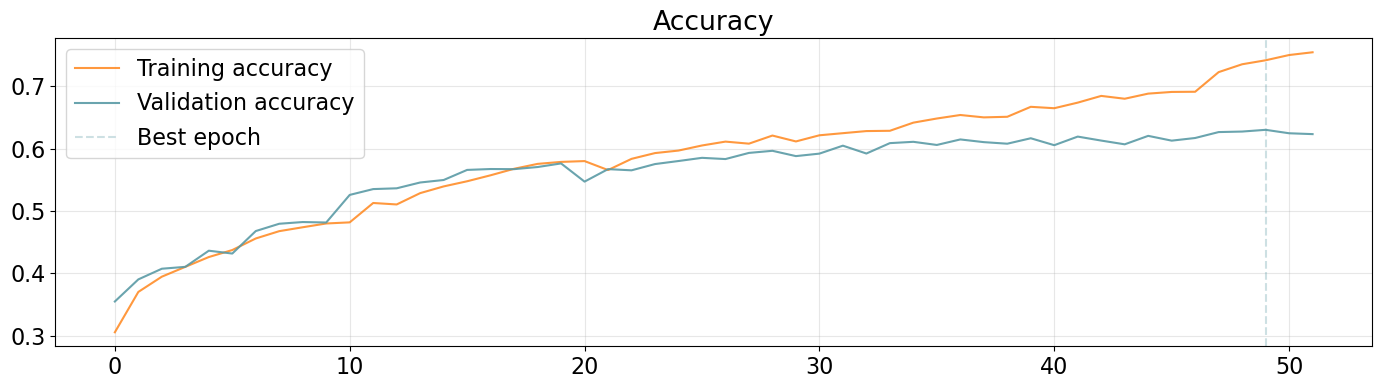

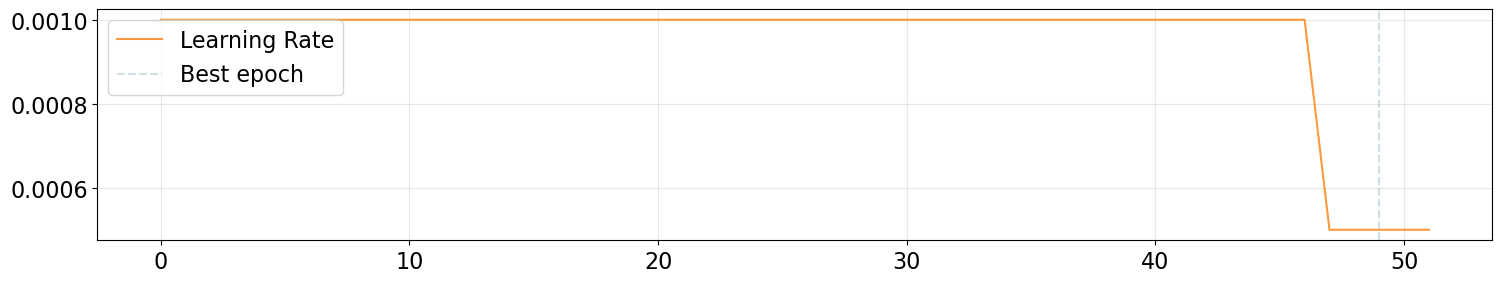

In [22]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Confusion Matrix

In [23]:
predictions = model.predict(X_test)

38/38 [==============================] - 3s 27ms/step


In [25]:
true_classes = y_test

In [26]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Pastel1', xticklabels=training_labels, yticklabels=training_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

ValueError: Classification metrics can't handle a mix of unknown and multiclass-multioutput targets

## Save Model

In [43]:
model.save('Autoencoder_3_7_4')

INFO:tensorflow:Assets written to: Autoencoder_3_7_4\assets


INFO:tensorflow:Assets written to: Autoencoder_3_7_4\assets


In [60]:
model = tfk.models.load_model('Autoencoder_3_7_3')

In [61]:
model_tuned = build_autoencoder(model)
model_tuned.summary()
tfk.utils.plot_model(model_tuned, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 36, 512)          538624    
 nal)                                                            
                                                                 
 Drop2 (Dropout)             (None, 36, 512)           0         
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 36, 128)          524416    
 Transpose)                                                      
                                                                 
 global_average_pooling1d_7   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                             

In [62]:
# Train the model
history = model_tuned.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
52/52 [==============================] - 9s 151ms/step - loss: 1.4505 - accuracy: 0.5706 - val_loss: 1.0324 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 2/200
52/52 [==============================] - 8s 146ms/step - loss: 0.7897 - accuracy: 0.7577 - val_loss: 0.9842 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 3/200
52/52 [==============================] - 9s 180ms/step - loss: 0.6244 - accuracy: 0.7959 - val_loss: 0.9869 - val_accuracy: 0.6678 - lr: 0.0010
Epoch 4/200
52/52 [==============================] - 9s 182ms/step - loss: 0.5172 - accuracy: 0.8365 - val_loss: 1.0710 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 5/200
52/52 [==============================] - 9s 178ms/step - loss: 0.4054 - accuracy: 0.8625 - val_loss: 1.1573 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 6/200
52/52 [==============================] - 9s 179ms/step - loss: 0.3468 - accuracy: 0.8873 - val_loss: 1.1364 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 7/200
52/52 [==============================] - 9s 181ms/st

KeyboardInterrupt: 

In [82]:
predictions = model_tuned.predict(X_test)

16/16 [==============================] - 0s 6ms/step


In [83]:
# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Pastel1', xticklabels=training_labels, yticklabels=training_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

ValueError: Classification metrics can't handle a mix of unknown and multiclass-multioutput targets